# Understanding the local electricity market

## 📖 Background
You work for an energy company in Australia. Your company builds solar panel arrays and then sells the energy they produce to industrial customers. The company wants to expand to the city of Melbourne in the state of Victoria. 

Prices and demand for electricity change every day. Customers pay for the energy received using a formula based on the local energy market's daily price.

Your company's pricing committee wants your team to estimate energy prices for the next 12-18 months to use those prices as the basis for contract negotiations.

In addition, the VP of strategy is researching investing in storage capacity (i.e., batteries) as a new source of revenue. The plan is to store some of the energy produced by the solar panels when pricing conditions are unfavorable and sell it by the next day on the open market if the prices are higher.

## 💾 The data
You have access to over five years of energy price and demand data ([source](https://www.kaggle.com/aramacus/electricity-demand-in-victoria-australia)):

- "date" - from January 1, 2015, to October 6, 2020.
- "demand" - daily electricity demand in MWh.
- "price" - recommended retail price in AUD/MWh.
- "demand_pos_price" - total daily demand at a positive price in MWh.
- "price_positive" - average positive price, weighted by the corresponding intraday demand in AUD/MWh.
- "demand_neg_price" - total daily demand at a negative price in MWh.
- "price_negative" - average negative price, weighted by the corresponding intraday demand in AUD/MWh.
- "frac_neg_price" - the fraction of the day when the demand traded at a negative price.
- "min_temperature" - minimum temperature during the day in Celsius.
- "max_temperature" - maximum temperature during the day in Celsius.
- "solar_exposure" - total daily sunlight energy in MJ/m^2.
- "rainfall" - daily rainfall in mm.
- "school_day" - "Y" if that day was a school day, "N" otherwise.
- "holiday" - "Y" if the day was a state or national holiday, "N" otherwise.

Note: The price was negative during some intraday intervals, so energy producers were paying buyers rather than vice-versa.

## 💪 Competition challenge

Create a report that covers the following:

1. How do energy prices change throughout the year? Are there any patterns by season or month of the year?
2. Build a forecast of daily energy prices the company can use as the basis of its financial planning.
3. Provide guidance on how much revenue the energy storage venture could generate per year using retail prices and a 70MWh storage system.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing

sns.set_style('whitegrid')

In [2]:
data = pd.read_csv('./data/energy_demand.csv', parse_dates=['date'])
data.head()

,date,demand,price,demand_pos_price,price_positive,demand_neg_price,price_negative,frac_neg_price,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
0,2015-01-01,99635.030,25.633696,97319.240,26.415953,2315.790,-7.240000,0.020833,13.3,26.9,23.6,0.0,N,Y
1,2015-01-02,129606.010,33.138988,121082.015,38.837661,8523.995,-47.809777,0.062500,15.4,38.8,26.8,0.0,N,N
2,2015-01-03,142300.540,34.564855,142300.540,34.564855,0.000,0.000000,0.000000,20.0,38.2,26.5,0.0,N,N
3,2015-01-04,104330.715,25.005560,104330.715,25.005560,0.000,0.000000,0.000000,16.3,21.4,25.2,4.2,N,N
4,2015-01-05,118132.200,26.724176,118132.200,26.724176,0.000,0.000000,0.000000,15.0,22.0,30.7,0.0,N,N


# Q1. How do energy prices change throughout the year? Are there any patterns by season or month of the year?

## Pivot display of energy prices by month of year

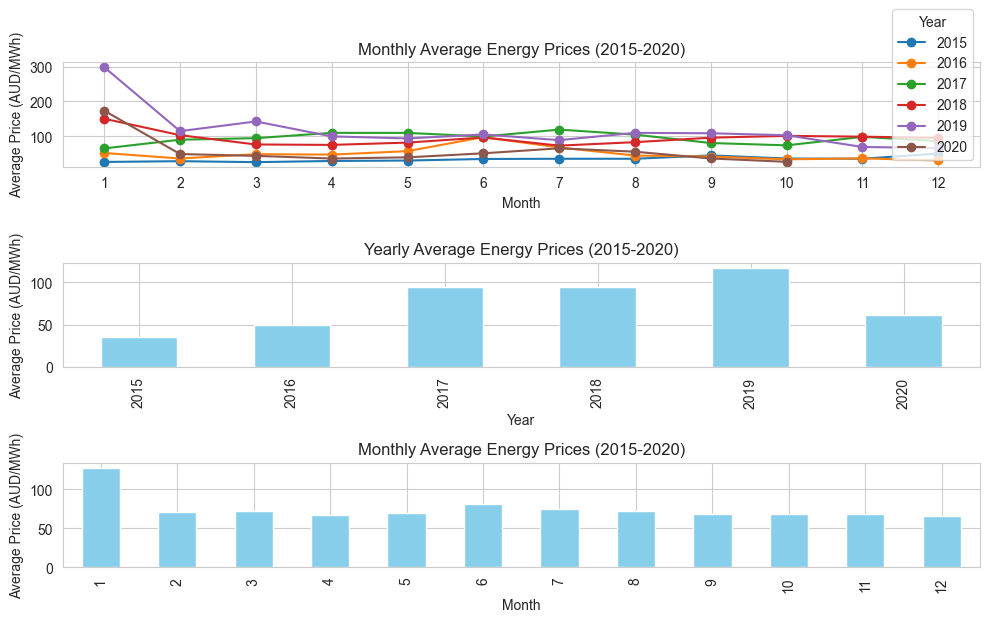

In [3]:
# Convert the 'date' column to datetime format
data['date'] = pd.to_datetime(data['date'])

# Extract the year and month for grouping
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month

# Group by year and month to calculate the mean price for each month
monthly_avg_price = data.groupby(['year', 'month'])['price'].mean().reset_index()

# Plot the data
plt.figure(figsize=(20, 10))

plt.subplot(3, 1, 1)

# Pivot the data for better visualization
monthly_avg_price_pivot = monthly_avg_price.pivot(index='month', columns='year', values='price')

for year in monthly_avg_price_pivot.columns:
    plt.plot(monthly_avg_price_pivot.index, monthly_avg_price_pivot[year], marker='o', label=year)

plt.title('Monthly Average Energy Prices (2015-2020)')
plt.xlabel('Month')
plt.ylabel('Average Price (AUD/MWh)')
plt.xticks(range(1, 13))
plt.legend(title='Year')
plt.grid(True)

plt.subplot(3, 1, 2)
# Insights on yearly trends
yearly_avg_price = data.groupby('year')['price'].mean()
yearly_avg_price.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Yearly Average Energy Prices (2015-2020)')
plt.xlabel('Year')
plt.ylabel('Average Price (AUD/MWh)')
plt.grid(True)


plt.subplot(3, 1, 3)
# Insights on monthly trends
yearly_avg_price = data.groupby('month')['price'].mean()
yearly_avg_price.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Monthly Average Energy Prices (2015-2020)')
plt.xlabel('Month')
plt.ylabel('Average Price (AUD/MWh)')
plt.grid(True)

plt.tight_layout()

In [4]:
# Avg price by year and month
monthly_avg_price_pivot

year,2015,2016,2017,2018,2019,2020
month,,,,,,
1,27.001545,52.619516,65.730310,150.606998,298.171896,173.693812
2,29.141102,36.824827,90.605335,103.533090,115.104347,49.595237
3,26.411552,49.110140,95.052161,76.968909,142.806870,44.353842
4,29.742708,47.962939,110.190800,75.737208,100.064075,36.746976
5,30.999966,57.855490,110.079402,82.332061,94.227316,40.140307
6,35.436807,97.932813,99.759536,96.996739,105.638227,51.709460
7,36.066474,68.365305,119.504540,73.610066,89.362782,65.949480
8,36.058255,45.195355,105.135469,83.555649,110.178120,56.271075
9,45.733888,42.346945,81.116821,96.391679,109.025825,36.857896


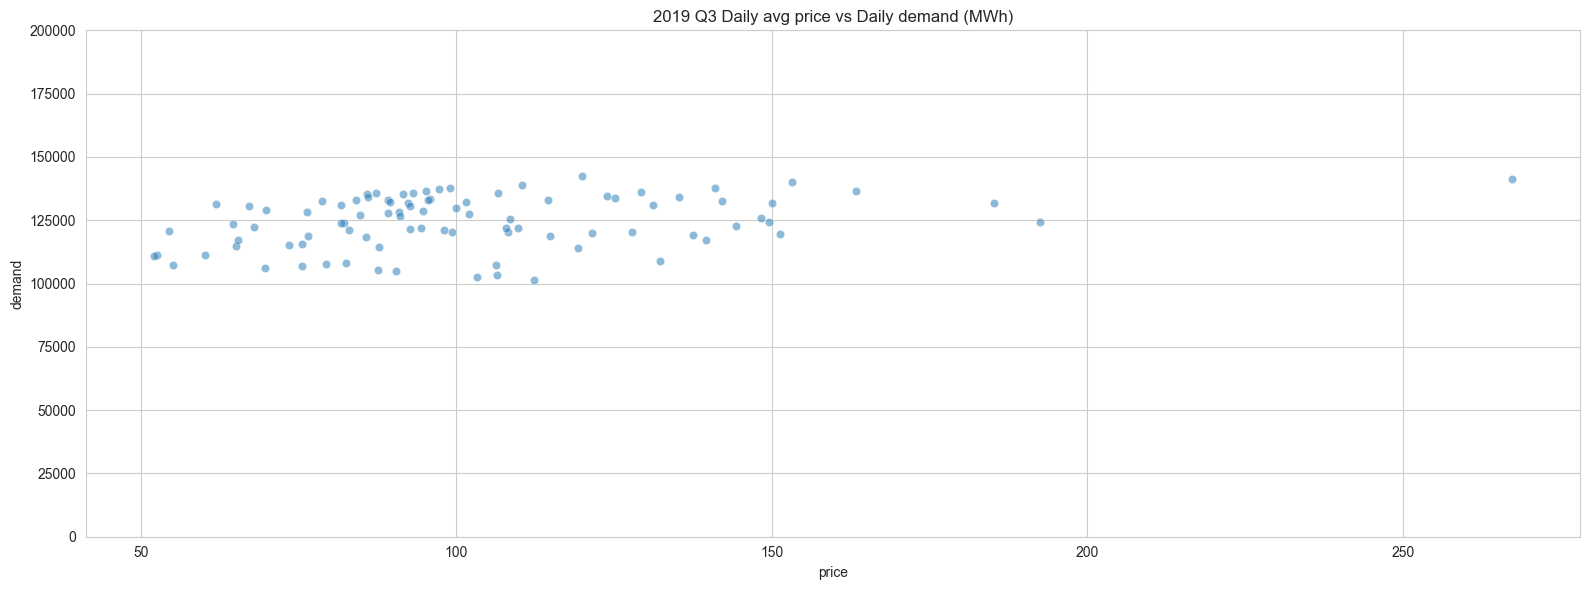

In [5]:
df1 = data.copy()
mask1 = (df1['price'] < 500)
mask2 = (df1['date'] >= '2019-07-01')
mask3 = (df1['date'] <= '2019-09-30')

plt.figure(figsize = (16, 6))
df1 = df1[mask1 & mask2 & mask3].reset_index(drop = True)
sns.scatterplot(data = df1, y = 'demand', x = 'price', alpha = 0.5)
plt.title("2019 Q3 Daily avg price vs Daily demand (MWh)")
plt.ylim(0, 200000)
plt.tight_layout()

## Time Series Decomposition

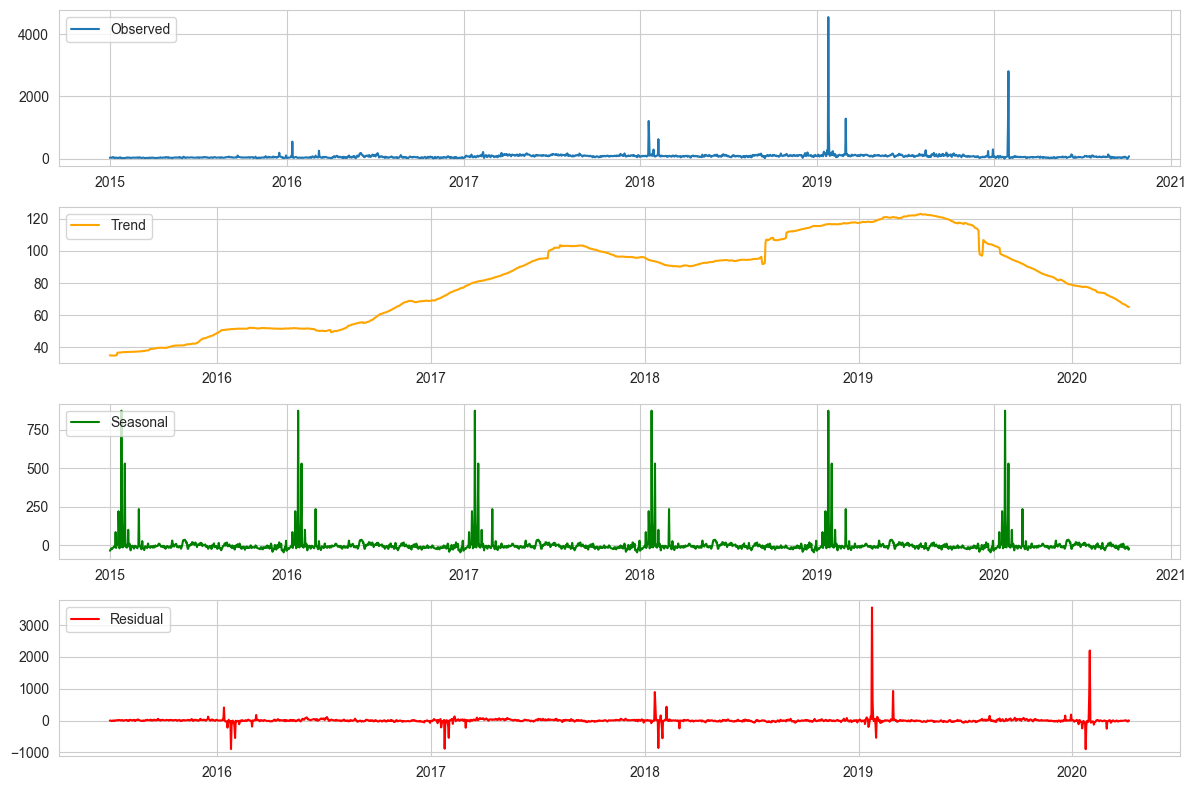

In [6]:
# Ensure the data is sorted by date
df1 = data.sort_values(by='date')

# Set the date as the index
df1.set_index('date', inplace=True)

# Use additive model instead due to negative and zero values in the price data
decomposition = seasonal_decompose(df1['price'], model='additive', period=365)

# Plot the decomposed components
plt.figure(figsize=(12, 8))

# Observed
plt.subplot(411)
plt.plot(decomposition.observed, label='Observed')
plt.legend(loc='upper left')

# Trend
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='orange')
plt.legend(loc='upper left')

# Seasonal
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal', color='green')
plt.legend(loc='upper left')

# Residual
plt.subplot(414)
plt.plot(decomposition.resid, label='Residual', color='red')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


# Q2. Build a forecast of daily energy prices the company can use as the basis of its financial planning.

/Users/brettlill/.pyenv/versions/3.10.6/envs/lang-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


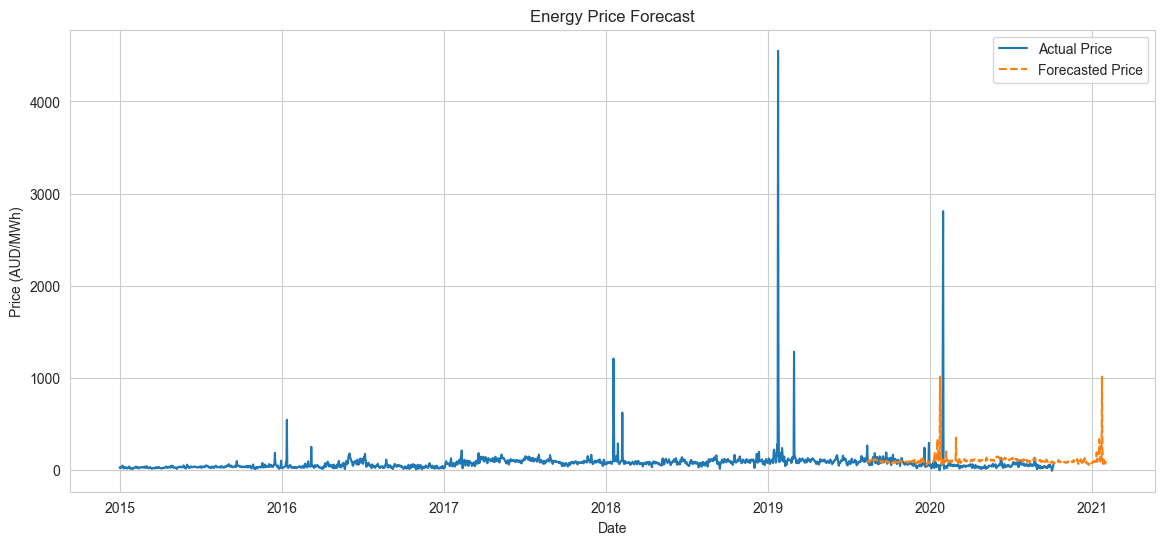

In [7]:
# Select the price column and drop any missing values
df1 = data.set_index('date')

price_series = df1['price'].dropna()

# Split the data into training and test sets
train_size = int(len(price_series) * 0.8)
train, test = price_series[:train_size], price_series[train_size:]

# Build the Holt-Winters model
model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=365).fit()

# Forecast the next 12-18 months (let's choose 540 days, approximately 18 months)
forecast_steps = 540
forecast = model.forecast(steps=forecast_steps)

# Plot the actual data and the forecast
plt.figure(figsize=(14, 6))
plt.plot(price_series, label='Actual Price')
plt.plot(forecast, label='Forecasted Price', linestyle='--')
plt.title('Energy Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price (AUD/MWh)')
plt.legend()
plt.grid(True)
plt.show()

forecast_df = forecast.to_frame(name='forecasted_price')

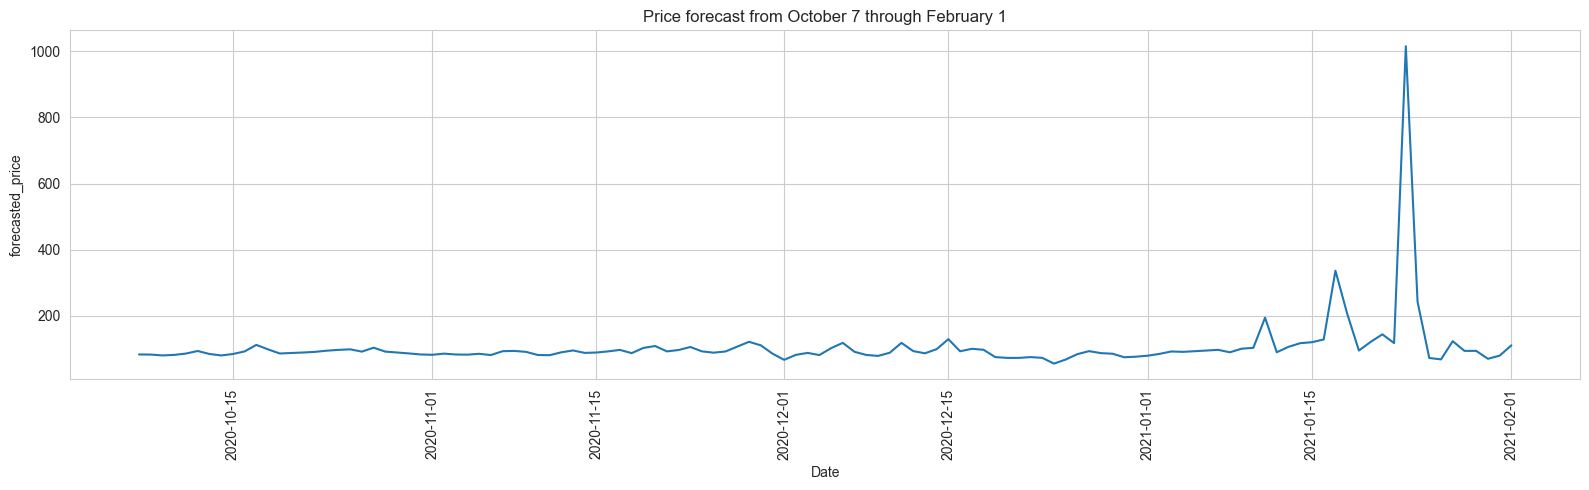

In [8]:
forecast = forecast_df.loc['2020-10-07':]
plt.figure(figsize = (16, 5))
sns.lineplot(data = forecast, x = forecast.index, y = 'forecasted_price')
plt.xticks(rotation = 90)
plt.title("Price forecast from October 7 through February 1")
plt.xlabel("Date")
plt.tight_layout()

# Q3. Provide guidance on how much revenue the energy storage venture could generate per year using retail prices and a 70MWh storage system.

## Model 1: Buy low, attempt to sell high the next day

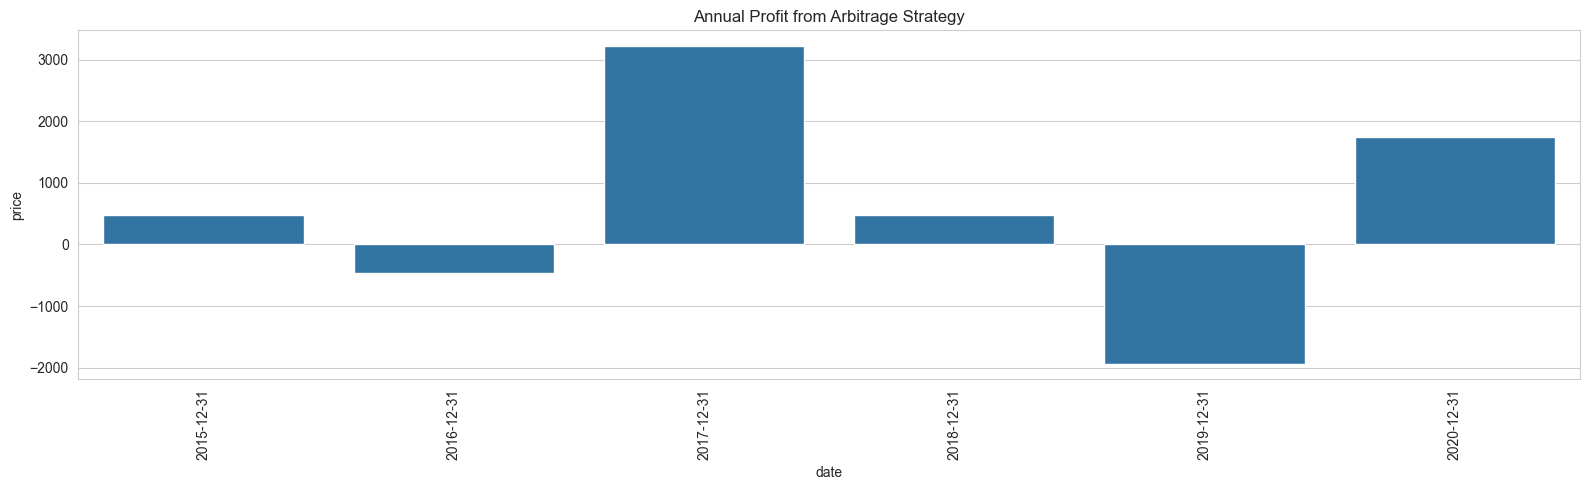

In [9]:
df1 = data.copy()
df1 = df1.set_index('date')
# Extract daily high and low prices
daily_low_price = df1['price'].resample('D').min()
daily_high_price = df1['price'].resample('D').max()

# Calculate the next day's high price (shifted by one day)
next_day_high_price = daily_high_price.shift(-1)

# Calculate daily profit assuming we buy at the day's low price and sell at the next day's high price
daily_profit = (next_day_high_price - daily_low_price) * 70  # 70 MWh storage capacity

# Monthly revenue estimate
monthly_revenue_estimate = daily_profit.resample('ME').sum()

# Annual revenue estimate
annual_revenue_estimate = daily_profit.resample('YE').sum()

# Display the annual revenue estimates
plt.figure(figsize=(16,5))
sns.barplot(annual_revenue_estimate)
plt.title("Annual Profit from Arbitrage Strategy")
plt.xticks(rotation = 90)
plt.tight_layout()

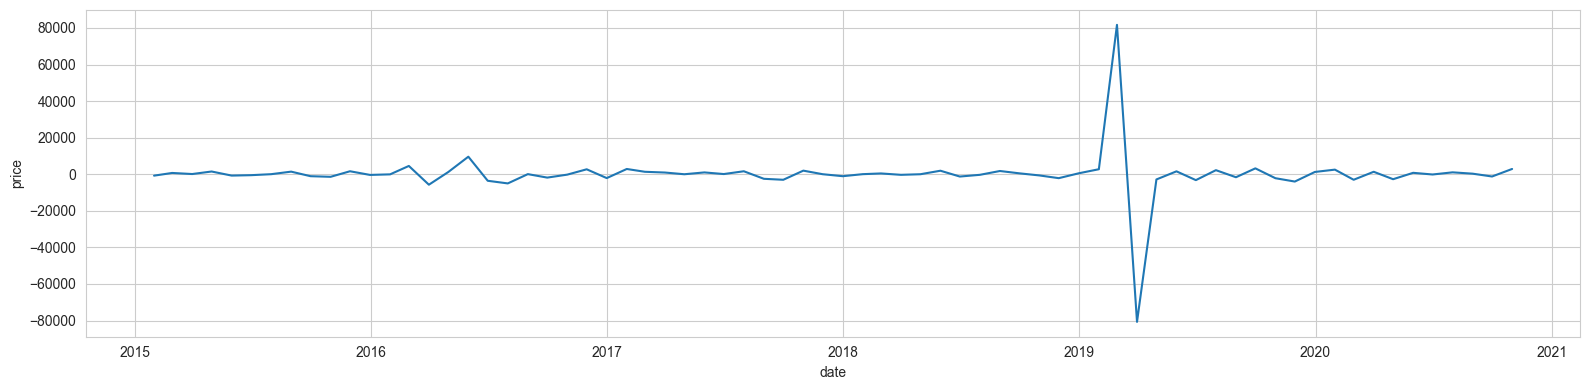

In [10]:
plt.figure(figsize = (16, 4))
sns.lineplot(monthly_revenue_estimate)
plt.tight_layout()

In [11]:
df = pd.merge(daily_low_price.reset_index(), next_day_high_price.reset_index(), on = 'date')
df = df.dropna()
df.columns = ['date', 'price_low', 'next_day_high']
df['profit'] = df['next_day_high'] - df['price_low']
df.set_index('date')
df.tail()

,date,price_low,next_day_high,profit
2100,2020-10-01,34.654671,-6.076028,-40.730699
2101,2020-10-02,-6.076028,-1.983471,4.092558
2102,2020-10-03,-1.983471,25.008614,26.992084
2103,2020-10-04,25.008614,36.764701,11.756087
2104,2020-10-05,36.764701,75.771059,39.006358


## Model 2: Use Time Series Forecast Model with Buy Signal

In [12]:
data = pd.read_csv("data/energy_demand.csv")
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Combine the actual prices with the forecasted prices
combined_prices = pd.concat([data['price'], forecast_df], axis=1)
combined_prices = combined_prices.dropna()

In [13]:

# Calculate daily profit based on the strategy
combined_prices['next_day_price'] = combined_prices['price'].shift(-1)
combined_prices['buy_signal'] = combined_prices['price'] < combined_prices['forecasted_price']
combined_prices['daily_profit'] = combined_prices['buy_signal'] * (combined_prices['next_day_price'] - combined_prices['price']) * 70

# Calculate monthly and annual profits
monthly_profit = combined_prices['daily_profit'].resample('ME').sum()
annual_profit = combined_prices['daily_profit'].resample('YE').sum()

# Convert to dataframes for better readability
monthly_profit_df = monthly_profit.to_frame(name='monthly_profit')
annual_profit_df = annual_profit.to_frame(name='annual_profit')

# Display the results
print("Monthly Profit from Arbitrage Strategy")
print(monthly_profit_df)

Monthly Profit from Arbitrage Strategy
            monthly_profit
2019-08-31     6056.368594
2019-09-30     9466.759672
2019-10-31     6006.873886
2019-11-30    -2747.078164
2019-12-31    18064.981473
2020-01-31    69546.784997
2020-02-29     2065.720001
2020-03-31     1345.511544
2020-04-30    -2719.128835
2020-05-31      771.969818
2020-06-30     2298.854077
2020-07-31     1121.414823
2020-08-31     3927.695732
2020-09-30    -1233.886785
2020-10-31     2878.147191


In [14]:
print("\nAnnual Profit from Arbitrage Strategy")
print(annual_profit_df)


Annual Profit from Arbitrage Strategy
            annual_profit
2019-12-31   36847.905460
2020-12-31   80003.082562


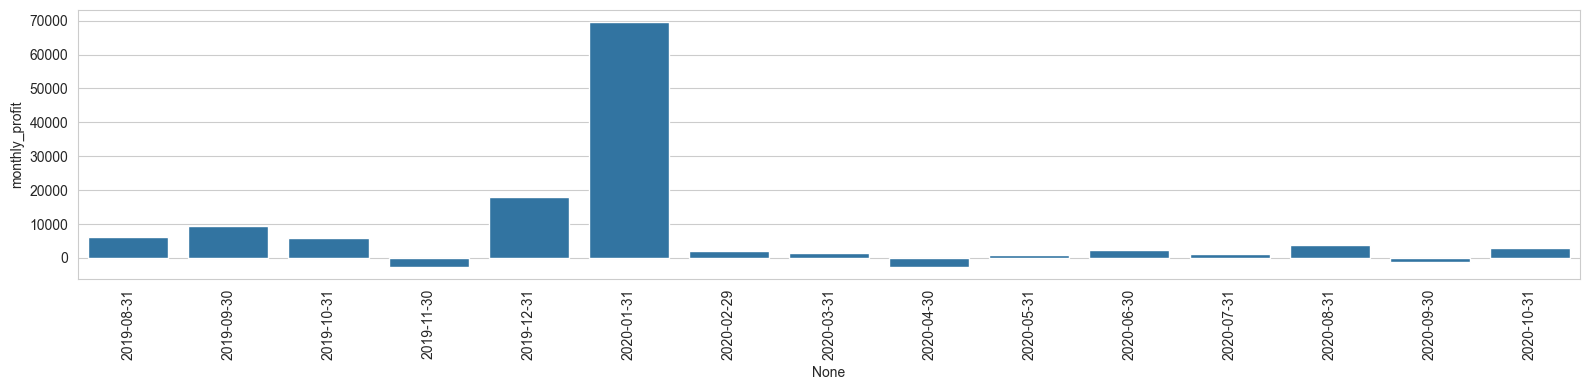

In [15]:
plt.figure(figsize = (16, 4))
sns.barplot(data = monthly_profit_df, x = monthly_profit_df.index, y = 'monthly_profit')
plt.xticks(rotation = 90)
plt.tight_layout()